In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings as w
%matplotlib inline

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

pd.set_option("display.max_rows", None,"display.max_columns", None)
w.simplefilter(action='ignore')
plt.style.use('seaborn')

## Read / Understand Dataset

In [134]:
# load data
df = pd.read_csv('fish_dataset.csv')
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [135]:
# set all column names to lower case
df.columns = df.columns.str.lower()

In [136]:
# rows x columns
df.shape

(159, 7)

In [137]:
# dataset data types
df.dtypes

species     object
weight     float64
length1    float64
length2    float64
length3    float64
height     float64
width      float64
dtype: object

In [138]:
# check if there are N/A values
df.isnull().sum()

species    0
weight     0
length1    0
length2    0
length3    0
height     0
width      0
dtype: int64

 - Species seems to be the only categorical data type -> let's see how many unique values there are & which ones

In [139]:
df['species'].value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: species, dtype: int64

<AxesSubplot:xlabel='species', ylabel='count'>

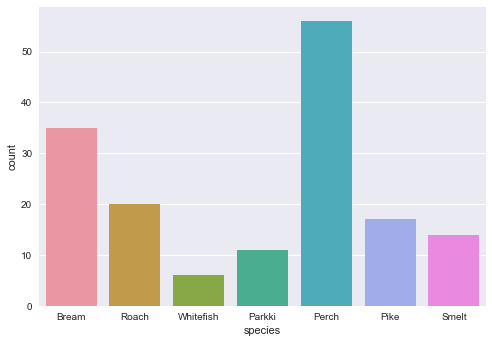

In [140]:
sns.countplot(data=df, x='species')

In [141]:
# statistical summary for numerical features
df.describe()

,weight,length1,length2,length3,height,width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


 - quick note 'weight' already seems to have one or more outliers when comparing the Mean with the Max

## Exploratory Data Analysis (EDA)

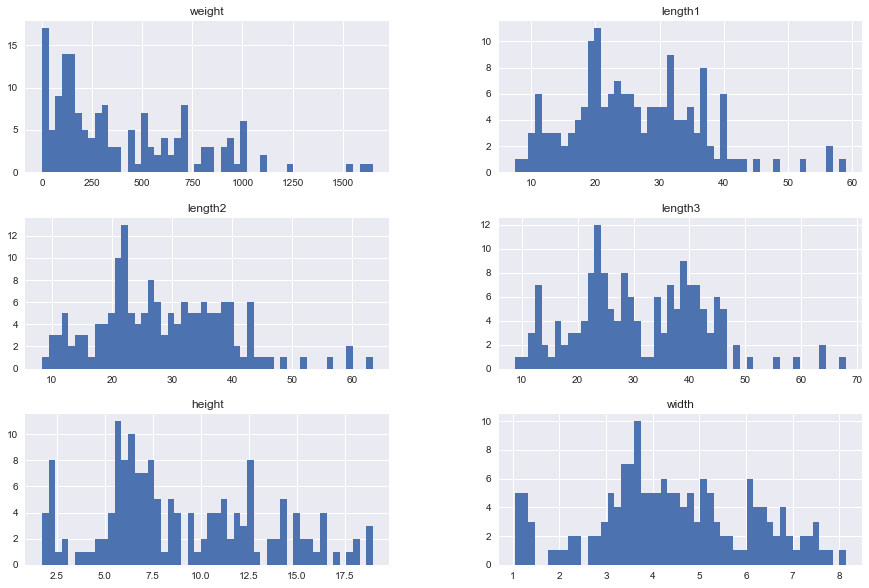

In [142]:
# histograms for numerical data type (quantity distribution)
df.hist(bins=50, figsize=(15,10))
plt.show()

Notes:
 - overall attributes are not normally distributed (bell-shape)
 - instead most are Double-Peaked (Bimodel) -> differently distributed; or Plateau distributed -> indicate many peaks are togther
 - the dependent attr has a Skewed distribution (right) -> positive skewed

### Univariate Analysis

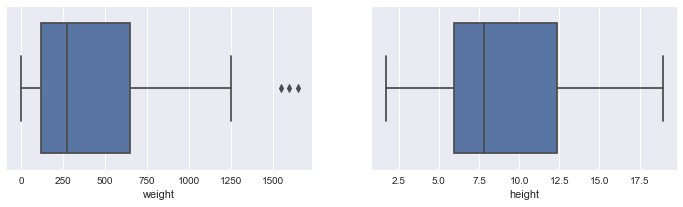

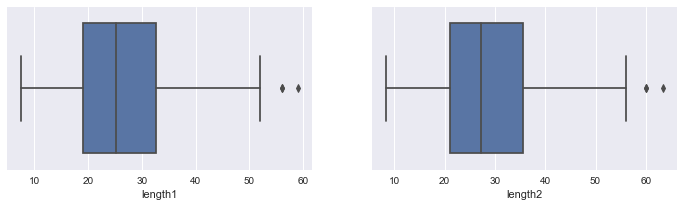

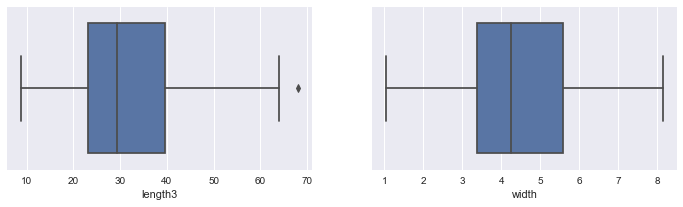

In [143]:
# we're gonna focus on numerical types here
num_attr = ['weight','height','length1','length2','length3','width']

i = 0
while i < 6:
    fig = plt.figure(figsize=[12,3])

    plt.subplot(1,2,1)
    sns.boxplot(x=num_attr[i], data=df)
    i += 1
    
    plt.subplot(1,2,2)
    sns.boxplot(x=num_attr[i], data=df)
    i += 1

    plt.show()

 - boxplot are good indicators of feature distribution (like histograms) & those points after the whiskers demonstrate outliers in the dataset

### Multivariate Analysis

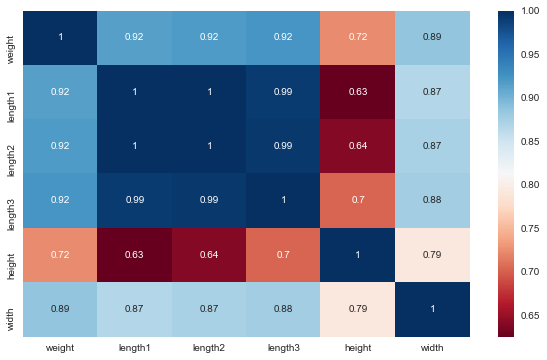

In [144]:
# heatmap correlation 
fig = plt.figure(figsize=[10,6])
sns.heatmap(df.corr(), annot=True, cmap='RdBu')
plt.show()

 - looking at the heatmap, features are mostly strongly correlated

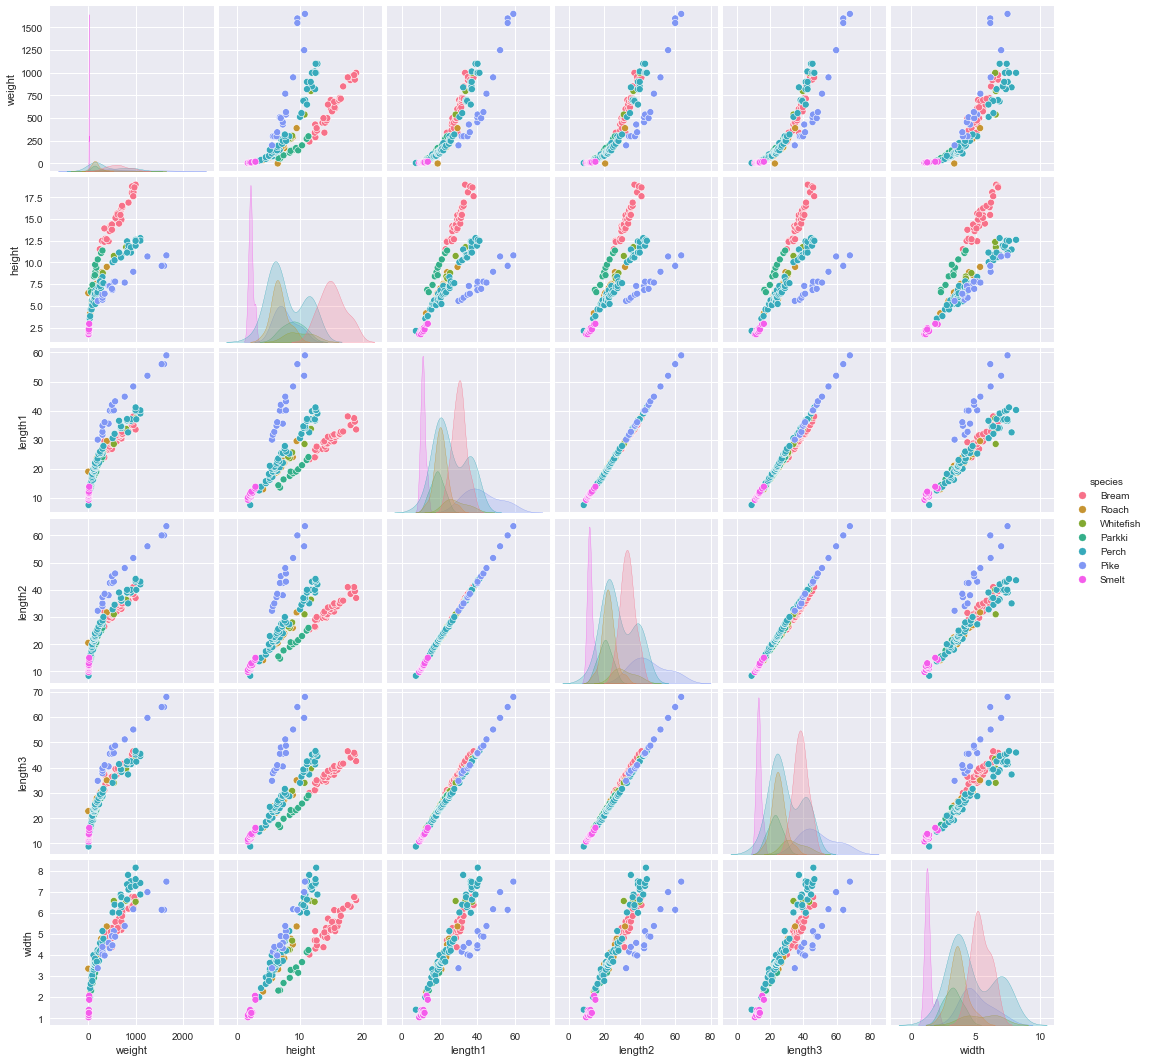

In [145]:
# now we're gonna look at correlations per Fish Type
sns.pairplot(df[['weight','height','length1','length2','length3','width','species']], diag_kind='kde', hue='species')

 - correlations in different fish species are also strong when looking at the pairplot above

In [146]:
# correlations for all attr with Dependant Variable (Weight)
df.corr()['weight'].sort_values(ascending=False)

weight     1.000000
length3    0.923044
length2    0.918618
length1    0.915712
width      0.886507
height     0.724345
Name: weight, dtype: float64

## Data Cleaning & Transformation

### Removing Outliers

In [147]:
# function for returning outliers
def return_outliers(df_column):
    Q1 = df[df_column].quantile(.25)
    Q3 = df[df_column].quantile(.75)
    IQR = Q3 - Q1
    print(f"IQR: {IQR}")
    upper_limit = Q3 + (1.5*IQR)
    print(f"upper_limit: {upper_limit}\n")
    outliers = df[df_column][(df[df_column] > upper_limit)]
    print(f"outliers:\n{outliers}")
    return outliers

 - Weight

In [148]:
# apply outlier function & remove them from dataset
outliers = return_outliers('weight')
to_remove = outliers.index.tolist()

IQR: 530.0
upper_limit: 1445.0

outliers:
142    1600.0
143    1550.0
144    1650.0
Name: weight, dtype: float64


In [149]:
df = df.drop(to_remove, axis=0)

 - Lentgh1

In [150]:
# apply outlier function & remove them from dataset
outliers = return_outliers('length1')
to_remove = outliers.index.tolist()

IQR: 13.125
upper_limit: 51.8125

outliers:
141    52.0
Name: length1, dtype: float64


In [151]:
df = df.drop(to_remove, axis=0)

## Feature Encoding

 - note that in reality is not best practice to transform data before train/test split but as we'll use pandas encoding & for simplicity we'll do it like this

In [152]:
df = pd.get_dummies(df, columns=['species'])
df.head()

,weight,length1,length2,length3,height,width,species_Bream,species_Parkki,species_Perch,species_Pike,species_Roach,species_Smelt,species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,1,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,1,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,1,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,1,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,1,0,0,0,0,0,0


## Train / Test Split

In [153]:
# split target variable & features to predict 
y = df['weight']
X = df.drop('weight', axis=1)

In [154]:
print(f"Shape of Dependent Variable y = {y.shape}")
print(f"Shape of Independent Variable X = {X.shape}")

Shape of Dependent Variable y = (155,)
Shape of Independent Variable X = (155, 12)


In [155]:
# split train/test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 2)

print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (124, 12)
Shape of X_test = (31, 12)
Shape of y_train = (124,)
Shape of y_test = (31,)


## Linear Regression

In [156]:
lin_reg_mod = LinearRegression() 
lin_reg_mod.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [157]:
pred = lin_reg_mod.predict(X_test) #Make Prediction for test (unseen) data
test_set_rmse = (np.sqrt(mean_squared_error(y_test, pred))) #Create metrics for accuracy
test_set_r2 = r2_score(y_test, pred)
print("RMSE value:",test_set_rmse)
print("R^2 value: ",test_set_r2)

RMSE value: 61.29762120650102
R^2 value:  0.9413410157765453


 - RMSE is not very large which indicates there's a good regression model
 - R-squared is very close to 1 which indicates there's a good level of accuracy 

<AxesSubplot:xlabel='weight'>

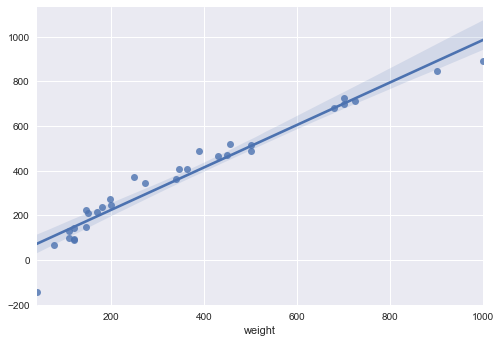

In [158]:
plt.figure()
sns.regplot(y_test,pred)

### Simple Linear Regression (with Height)

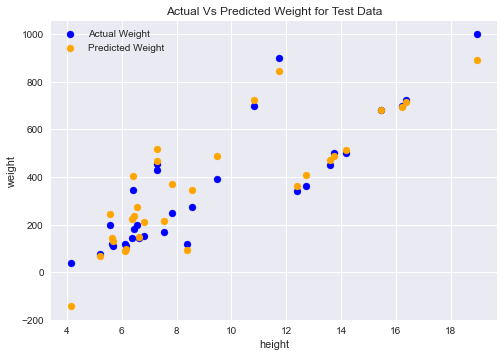

In [160]:
# plot actual vs predicted
plt.scatter(X_test['height'], y_test, color='blue', label = 'Actual Weight')
plt.scatter(X_test['height'], lin_reg_mod.predict(X_test), color='orange', label = 'Predicted Weight')
plt.xlabel('height')
plt.ylabel('weight')
plt.rcParams["figure.figsize"] = (10,6) 
plt.title('Actual Vs Predicted Weight for Test Data')
plt.legend()
plt.show()

In [168]:
# SLR for height
lm = LinearRegression()
temp_X_train = X_train[['height']]
temp_X_test = X_test[['height']]
lm.fit(temp_X_train, y_train)

# coefficients
print("coeficient is:", lm.coef_)
print('intercept is : ', lm.intercept_)
print("formula: y = mx + b - turns out to be:")
print(f"Y = {lm.coef_} * x + {lm.intercept_}")

coeficient is: [59.93429762]
intercept is :  -155.24450562941644
formula: y = mx + b - turns out to be:
Y = [59.93429762] * x + -155.24450562941644


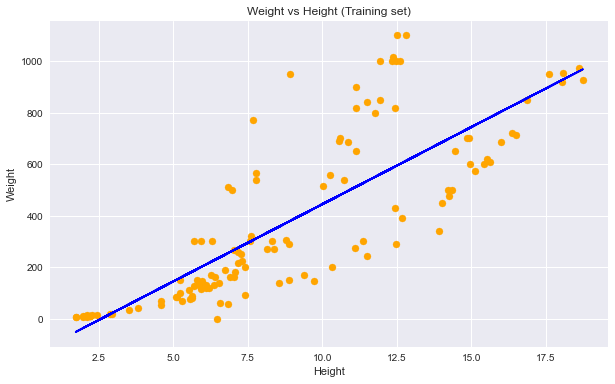

In [167]:
# visualize Training set results
plt.scatter(temp_X_train, y_train, color = 'orange')
plt.plot(temp_X_train, lm.predict(temp_X_train), color = 'blue')
plt.title('Weight vs Height (Training set)')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

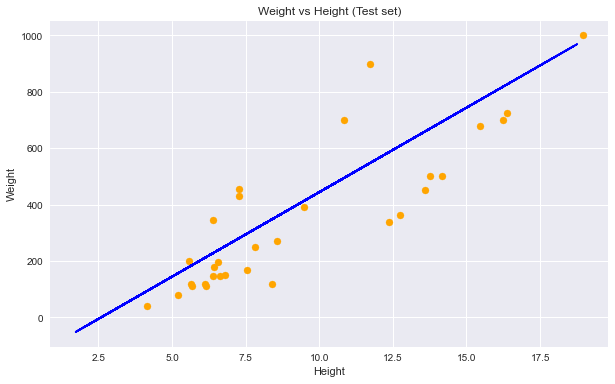

In [169]:
# visualize Test set results
plt.scatter(temp_X_test, y_test, color = 'orange')
plt.plot(temp_X_train, lm.predict(temp_X_train), color = 'blue')
plt.title('Weight vs Height (Test set)')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

In [171]:
print("Height of 10 - is equivalent Weight: ", lm.predict([[10]]))

Height of 10 - is equivalent Weight:  [444.0984706]


## Multiple Linear Regression (with Scaled Features)

In [173]:
# repeting process just for good practice
y = df['weight']
X = df.drop('weight', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [176]:
print(X_scaled)

[[-0.25772653 -0.231443   -0.03672638 ... -0.38490018 -0.3151044
  -0.20067002]
 [-0.16752588 -0.13695573  0.07827542 ... -0.38490018 -0.3151044
  -0.20067002]
 [-0.17880096 -0.11595856  0.06869194 ... -0.38490018 -0.3151044
  -0.20067002]
 ...
 [-1.50926051 -1.53326754 -1.58925077 ... -0.38490018  3.17355141
  -0.20067002]
 [-1.38523462 -1.39678594 -1.455082   ... -0.38490018  3.17355141
  -0.20067002]
 [-1.31758413 -1.32329584 -1.35924716 ... -0.38490018  3.17355141
  -0.20067002]]


In [178]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.2,random_state = 2)

print(f"Shape of X_train = {X_train.shape}")
print(f"Shape of X_test = {X_test.shape}")
print(f"Shape of y_train = {y_train.shape}")
print(f"Shape of y_test = {y_test.shape}")

Shape of X_train = (124, 12)
Shape of X_test = (31, 12)
Shape of y_train = (124,)
Shape of y_test = (31,)


In [179]:
CV, R2_train, R2_test = ([] for i in range(3))

# function to evaluate & score models
def prediction_model(model, model_name):
    # training model
    model.fit(X_train, y_train)
    # R2 score for train set
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train,y_pred_train)
    R2_train.append(round(R2_train_model,2))
    # R2 score for test set
    y_pred_test = model.predict(X_test)
    R2_test_model = r2_score(y_test,y_pred_test)
    R2_test.append(round(R2_test_model,2))
    # R2 mean of train set using Cross Validation
    cross_val = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean,2))    
    # print results
    print("Train R2-score :",round(R2_train_model,2))
    print("Test R2-score :",round(R2_test_model,2))
    print("Train CV scores :",cross_val)
    print("Train CV mean :",round(cv_mean,2))    
    # Plotting Graphs 
    # Residual Plot of train data
    fig, ax = plt.subplots(1,2,figsize = (10,4))
    ax[0].set_title('Residual Plot of Train samples')
    sns.distplot((y_train-y_pred_train),hist = False,ax = ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')    
    # Y_test vs Y_train scatter plot
    ax[1].set_title('y_test vs y_pred_test')
    ax[1].scatter(x = y_test, y = y_pred_test)
    ax[1].set_xlabel('y_test')
    ax[1].set_ylabel('y_pred_test')
    
    plt.show()

Train R2-score : 0.95
Test R2-score : 0.94
Train CV scores : [0.93207468 0.92257867 0.91910166 0.94463518 0.91815254]
Train CV mean : 0.93


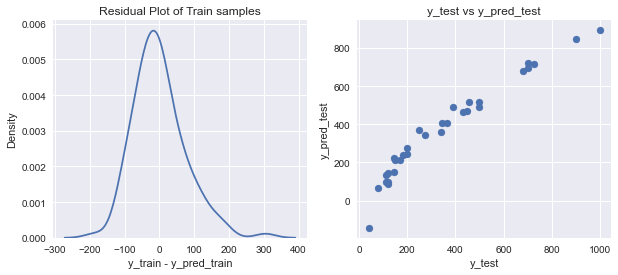

In [182]:
lr = LinearRegression()
prediction_model(lr,"Linear_regressor.pkl")

In [184]:
print('Intercept: \n', lr.intercept_)
print()
print('Coefficients: \n', lr.coef_)

Intercept: 
 373.0708014799888

Coefficients: 
 [  93.96310563  200.68390727 -163.47874876  203.49865727   69.12096105
  -57.84721473  -18.01572844   13.40851251   -1.98947916   -3.12720888
   82.71725811    1.35256466]
